In [1]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2021-03-26 00:46:18--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2021-03-26 00:46:18--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/master [following]
--2021-03-26 00:46:18--  https://codeload.github.com/karolpiczak/ESC-50/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [           <=>      ] 615

In [2]:
!unzip -qq master.zip

In [3]:
%cd ESC-50-master

/content/ESC-50-master


In [4]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [5]:
df = pd.read_csv('meta/esc50.csv')

In [6]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [7]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [8]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [9]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [10]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [11]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

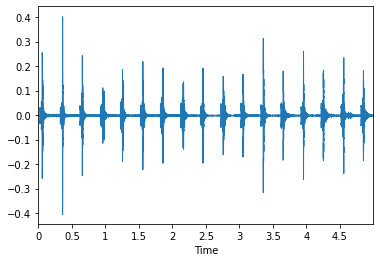

In [12]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

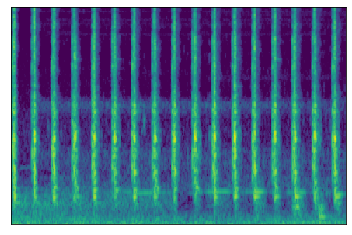

In [13]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [14]:
train_data = ESC50Data('audio', train, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [15]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [16]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [17]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [18]:
print(device)

cuda:0


In [19]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [20]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [22]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [23]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch - 1 Train-Loss : 3.7331921291351318
Epoch - 1 Valid-Loss : 3.2101055431365966 Valid-Accuracy : 0.205
Epoch - 2 Train-Loss : 3.0392812299728393
Epoch - 2 Valid-Loss : 2.7270143604278565 Valid-Accuracy : 0.3175
Epoch - 3 Train-Loss : 2.438523339033127
Epoch - 3 Valid-Loss : 2.355127935409546 Valid-Accuracy : 0.38
Epoch - 4 Train-Loss : 1.9281241762638093
Epoch - 4 Valid-Loss : 2.2556586360931394 Valid-Accuracy : 0.405
Epoch - 5 Train-Loss : 1.4723050218820573
Epoch - 5 Valid-Loss : 2.0679096031188964 Valid-Accuracy : 0.4425
Epoch - 6 Train-Loss : 1.1206655579805374
Epoch - 6 Valid-Loss : 2.0031998348236084 Valid-Accuracy : 0.4375
Epoch - 7 Train-Loss : 0.8315801480412484
Epoch - 7 Valid-Loss : 1.8844857597351075 Valid-Accuracy : 0.4825
Epoch - 8 Train-Loss : 0.68346949249506
Epoch - 8 Valid-Loss : 1.8935389375686646 Valid-Accuracy : 0.49
Epoch - 9 Train-Loss : 0.5100122584402561
Epoch - 9 Valid-Loss : 1.8242253303527831 Valid-Accuracy : 0.505
Epoch - 10 Train-Loss : 0.4141656768321

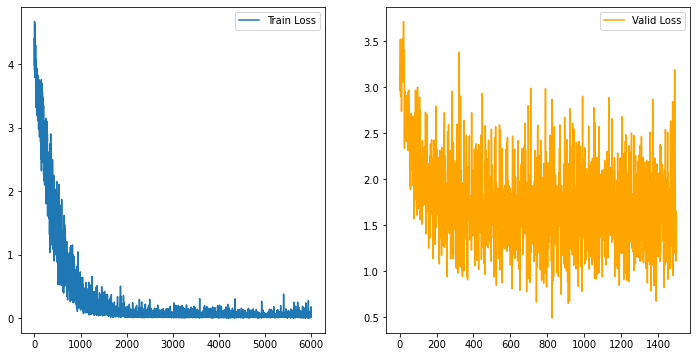

In [24]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [25]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [26]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch - 1 Train-Loss : 2.451817420721054
Epoch - 1 Valid-Loss : 1.6399104976654053 Valid-Accuracy : 0.54
Epoch - 2 Train-Loss : 1.1225686341524124
Epoch - 2 Valid-Loss : 1.471606159210205 Valid-Accuracy : 0.555
Epoch - 3 Train-Loss : 0.6672650861740113
Epoch - 3 Valid-Loss : 1.3105535888671875 Valid-Accuracy : 0.6375
Epoch - 4 Train-Loss : 0.4229533948004246
Epoch - 4 Valid-Loss : 1.5102234983444214 Valid-Accuracy : 0.59
Epoch - 5 Train-Loss : 0.3445495883375406
Epoch - 5 Valid-Loss : 1.112137303352356 Valid-Accuracy : 0.7075
Epoch - 6 Train-Loss : 0.22551575008779765
Epoch - 6 Valid-Loss : 1.1062452936172484 Valid-Accuracy : 0.715
Epoch - 7 Train-Loss : 0.17731969287618995
Epoch - 7 Valid-Loss : 1.006642290353775 Valid-Accuracy : 0.7275
Epoch - 8 Train-Loss : 0.179346297737211
Epoch - 8 Valid-Loss : 1.3393234705924988 Valid-Accuracy : 0.7
Epoch - 9 Train-Loss : 0.15003995141014456
Epoch - 9 Valid-Loss : 1.3848585128784179 Valid-Accuracy : 0.685
Changed learning rate to 2e-05
Epoch - 1

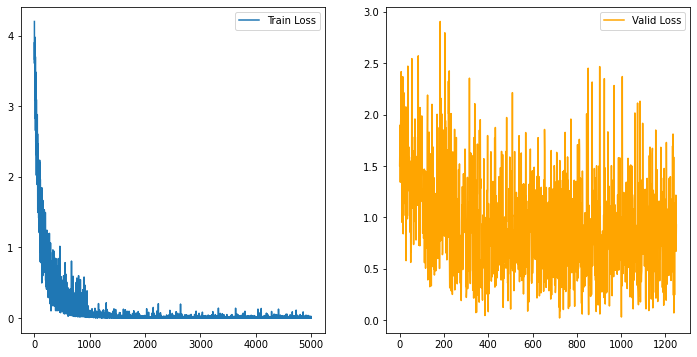

In [27]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])